In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.datasets import imdb


def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}

    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.

    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]

    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for ngram_value in range(2, ngram_range + 1):
            for i in range(len(new_list) - ngram_value + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

In [2]:
# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 1
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 5

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(
    np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(
    np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(
        np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(
        np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238
Average test sequence length: 230
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)


In [3]:
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 50)           1000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 1,000,051
Trainable params: 1,000,051
Non-trainable params: 0
_________________________________________________________________


In [4]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 19s 749us/sample - loss: 0.6122 - accuracy: 0.7457 - val_loss: 0.5035 - val_accuracy: 0.8218
Epoch 2/5
25000/25000 [==============================] - 22s 861us/sample - loss: 0.4066 - accuracy: 0.8634 - val_loss: 0.3743 - val_accuracy: 0.8615
Epoch 3/5
25000/25000 [==============================] - 20s 803us/sample - loss: 0.3060 - accuracy: 0.8940 - val_loss: 0.3236 - val_accuracy: 0.8754
Epoch 4/5
25000/25000 [==============================] - 20s 803us/sample - loss: 0.2548 - accuracy: 0.9119 - val_loss: 0.2965 - val_accuracy: 0.8857
Epoch 5/5
25000/25000 [==============================] - 24s 968us/sample - loss: 0.2208 - accuracy: 0.9238 - val_loss: 0.2850 - val_accuracy: 0.8877


In [5]:
model.save_weights("unigram_imdb_weights.h5")

In [42]:
train_pred = model.predict(x_train)
print(((train_pred[:, 0] > 0.5) == y_train).mean())

test_pred = model.predict(x_test)
print(((test_pred[:, 0] > 0.5) == y_test).mean())

0.93268
0.88768


By the way, this is how you load weights from a trained and saved model

In [6]:
import h5py

file = h5py.File("unigram_imdb_weights.h5", "r")
embeddings = file["embedding"]["embedding"]["embeddings:0"][()]
file.close()

and this is how you map indices to words

In [32]:
word_index = imdb.get_word_index()
index_word = {v: k for k, v in word_index.items()}

Now let's check the averaged embeddings

In [36]:
from tensorflow.keras import models
nodense_model = models.Model(inputs=model.input, outputs=model.layers[1].output)
nodense_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(None, 400)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 400, 50)           1000000   
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
Total params: 1,000,000
Trainable params: 1,000,000
Non-trainable params: 0
_________________________________________________________________


In [44]:
from sklearn import decomposition

In [ ]:
embedded_reviews = nodense_model.predict(x_train)

pca = decomposition.PCA(n_components=10)
embeddings_2d = pca.fit_transform(embedded_reviews)
print(pca.explained_variance_)

[4.0337805e-02 2.8822201e-03 2.8990078e-05 7.0216015e-06 6.0203802e-06
 4.3343575e-06 3.8313237e-06 3.5182215e-06 2.9388102e-06 2.5806503e-06]


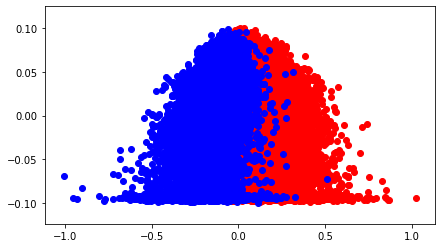

In [54]:
plt.figure(figsize=(7, 4))
ind = np.where(y_train == 0)[0]
plt.scatter(embeddings_2d[ind, 0], embeddings_2d[ind, 1], color="red")
ind = np.where(y_train == 1)[0]
plt.scatter(embeddings_2d[ind, 0], embeddings_2d[ind, 1], color="blue")
plt.show()

In [55]:
embedded_reviews = nodense_model.predict(x_test)

pca = decomposition.PCA(n_components=10)
embeddings_2d = pca.fit_transform(embedded_reviews)
print(pca.explained_variance_)

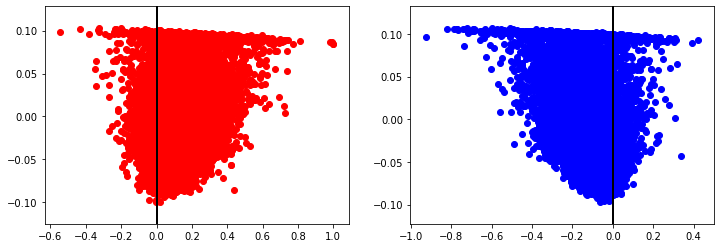

In [60]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
ind = np.where(y_test == 0)[0]
plt.scatter(embeddings_2d[ind, 0], embeddings_2d[ind, 1], color="red")
plt.axvline(x=0.0, color="black", linewidth=2.0)

plt.subplot(122)
ind = np.where(y_test == 1)[0]
plt.scatter(embeddings_2d[ind, 0], embeddings_2d[ind, 1], color="blue")
plt.axvline(x=0.0, color="black", linewidth=2.0)
plt.show()